# Evaluation

Auswertung der Runs - Durchschnittswerte über alle Runs pro Model+Strategy

In [92]:
import sys
sys.path.append('..')

import sqlite3
import pandas as pd
import plotly.express as px
from survey import scoring

connection = sqlite3.connect('../data/survey.db')
cursor = connection.cursor()

In [93]:
# Alle verfügbaren Strategien ermitteln

cursor.execute("""
    SELECT DISTINCT s.name
    FROM runs r
    JOIN strategies s ON r.strategy_id = s.id
    ORDER BY s.name
""")

strategies = [row[0] for row in cursor.fetchall()]
print(f"Verfügbare Strategien: {strategies}")

Verfügbare Strategien: ['oneshot_llm_explicit', 'oneshot_llm_opinion', 'oneshot_none', 'oneshot_test', 'questionbyquestion_llm_explicit', 'questionbyquestion_llm_opinion', 'questionbyquestion_none', 'questionbyquestion_test']


In [94]:
# Evaluation für jede Strategie separat

for strategy_name in strategies:
    
    print(f"\n{'='*80}")
    print(f"STRATEGIE: {strategy_name}")
    print(f"{'='*80}\n")
    
    # Model-Kombinationen für diese Strategie
    cursor.execute("""
        SELECT 
            m.id as model_id,
            m.name as model_name,
            s.id as strategy_id,
            s.name as strategy_name,
            COUNT(DISTINCT r.id) as run_count
        FROM runs r
        JOIN models m ON r.model_id = m.id
        JOIN strategies s ON r.strategy_id = s.id
        WHERE s.name = ?
        GROUP BY m.id, s.id
        ORDER BY m.name
    """, (strategy_name,))
    
    combinations = cursor.fetchall()
    
    results = []
    
    for model_id, model_name, strategy_id, strategy_name_db, run_count in combinations:
        
        # Durchschnittliche Antworten über alle Runs
        cursor.execute("""
            SELECT 
                resp.question_id,
                AVG(resp.answer) as avg_answer
            FROM responses resp
            JOIN runs r ON resp.run_id = r.id
            WHERE r.model_id = ? AND r.strategy_id = ?
            GROUP BY resp.question_id
            ORDER BY resp.question_id
        """, (model_id, strategy_id))
        
        rows = cursor.fetchall()
        responses = {q_id: avg_answer for q_id, avg_answer in rows}
        
        # Scoring
        all_scores = scoring.calculate_all_milieu_scores(responses)
        result = scoring.get_primary_milieu(all_scores)
        
        results.append({
            'Model': model_name,
            'Runs': run_count,
            'Primary Milieu': result['primary_milieu'],
            'Probability': f"{result['primary_probability']:.3f}" if result['primary_probability'] != '---' else '---',
            'Secondary Milieu': result['secondary_milieu'],
            'Sec. Prob.': f"{result['secondary_probability']:.3f}" if result['secondary_probability'] != '---' else '---',
            'Unclear Candidates': result['candidates'],
            'Unclear Probabilities': result['probabilities'],
            'Confidence': result['confidence']
        })
    
    # Output Tabelle
    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    print()


STRATEGIE: oneshot_llm_explicit

            Model  Runs       Primary Milieu Probability Secondary Milieu Sec. Prob.              Unclear Candidates                    Unclear Probabilities Confidence
   Claude Haikaku     4 Adaptiv-Pragmatische       0.562          Prekäre      0.454                             ---                                      ---   moderate
      Claude Opus     4 Adaptiv-Pragmatische       0.659              ---        ---                             ---                                      ---       high
    Deepseek Chat     4                  ---         ---              ---        --- [Adaptiv-Pragmatische, Prekäre] [0.5043603545751304, 0.4869821093076748]        low
Deepseek Reasoner     4 Adaptiv-Pragmatische       0.681          Prekäre      0.590                             ---                                      ---   moderate
          GPT-5.2     4                  ---         ---              ---        --- [Adaptiv-Pragmatische, Prekäre] [0.4

## Sinus-Milieus: Kurzbeschreibungen

### Obere Schicht / Liberal-Intellektuell
- **Konservativ-Etablierte**: Klassisches Establishment, Exklusivität, Statusbewusstsein, Verantwortungsethik
- **Postmaterielle**: Bildungselite, intellektuell, Umweltbewusstsein, Kulturorientierung
- **Performer**: Effizienzorientiert, technokratisch, Leistung, globalwirtschaftlich

### Moderne Mitte
- **Expeditive**: Kreativ, urban, Digital Natives, Trendsetter, kosmopolitisch
- **Neo-Ökologische**: Transformations-Treiber, optimistischer Environmentalismus, systemischer Wandel
- **Adaptiv-Pragmatische**: Moderne Mitte, flexibel, pragmatisch, moderate Werte **OHNE Extreme**

### Untere Mitte / Unterschicht
- **Konsum-Hedonistische**: Unterhaltung, Fun, Shopping, Markenbewusst, Work-Life-Balance
- **Prekäre**: Ökonomische Restriktionen, Anerkennungssuche, Teilhabe-Wunsch
- **Nostalgisch-Bürgerliche**: Harmonie, Sicherheit, Gemeinschaft, Stabilität, traditionell
- **Traditionelle**: Ältere Generation, kleinbürgerlich, Ordnung, Sicherheit, Anti-Modern

In [95]:
# performance vergleichen

query = """
    SELECT
        m.name AS model,
        s.name AS strategy,
        AVG(r.duration_time) AS avg_duration,
        AVG(r.prompt_tokens) AS avg_prompt_tokens,
        AVG(r.completion_tokens) AS avg_completion_tokens,
        COUNT(r.id) AS run_count
    FROM runs r
    JOIN models m ON r.model_id = m.id
    JOIN strategies s ON r.strategy_id = s.id
    GROUP BY m.id, s.id 
    ORDER BY m.name, s.name
"""

df = pd.read_sql_query(query, connection)

df.head()

,model,strategy,avg_duration,avg_prompt_tokens,avg_completion_tokens,run_count
0,Claude Haikaku,oneshot_llm_explicit,2.413947,1898.0,441.0,4
1,Claude Haikaku,oneshot_llm_opinion,2.243162,1892.0,441.0,4
2,Claude Haikaku,oneshot_none,2.344973,1805.0,441.0,3
3,Claude Haikaku,oneshot_test,2.313625,1901.0,441.0,4
4,Claude Haikaku,questionbyquestion_llm_explicit,24.540965,28303.0,1450.0,3


In [96]:
# barchart
fig = px.bar(
    df,
    x='model',
    y='avg_duration',
    color='strategy',
    barmode='group',
    height=600
)

fig.show()

In [97]:
fig_prompt_tokens = px.bar(
    df,
    x='model',
    y='avg_prompt_tokens',
    color='strategy',
    barmode='group',
    height=600
)

fig_prompt_tokens.show()

In [98]:
fig_completion_tokens = px.bar(
    df,
    x='model',
    y='avg_completion_tokens',
    color='strategy',
    barmode='group',
    height=600
)

fig_completion_tokens.show()

In [99]:
# antwortverteilung
query_answers = """
    SELECT 
        q.id as question_id,
        q.label as question_label,
        m.name as model,
        AVG(resp.answer) as avg_answer
    FROM responses resp
    JOIN runs r ON resp.run_id = r.id
    JOIN models m ON r.model_id = m.id
    JOIN questions q ON resp.question_id = q.id
    GROUP BY q.id, m.id
    ORDER BY q.id, m.name
"""

df_answers = pd.read_sql_query(query_answers, connection)
df_answers.head()

,question_id,question_label,model,avg_answer
0,1,TRADITION_KERN,Claude Haikaku,3.037037
1,1,TRADITION_KERN,Claude Opus,3.074074
2,1,TRADITION_KERN,Deepseek Chat,3.560000
3,1,TRADITION_KERN,Deepseek Reasoner,3.037037
4,1,TRADITION_KERN,GPT-5.2,2.851852


In [100]:
# Pivot: Fragen als Zeilen, Models als Spalten
df_pivot = df_answers.pivot(
    index='question_label',  # oder 'question_id'
    columns='model',
    values='avg_answer'
)

print(df_pivot)

model                      Claude Haikaku  Claude Opus  Deepseek Chat  \
question_label                                                          
ANPASSUNG_VS_GESTALTUNG          2.000000     1.888889       2.629630   
AUTONOMIE_WUNSCH                 3.555556     4.000000       3.807692   
BEZIEHUNGSTIEFE                  3.259259     3.407407       3.576923   
FAMILIE_PRIORITAET               3.960000     3.000000       3.961538   
GEMEINWOHL_ORIENTIERUNG          3.407407     3.925926       3.571429   
HARMONIE_VS_LEISTUNG             3.148148     3.111111       3.840000   
HOCHKULTUR_INTERESSE             3.259259     3.518519       3.500000   
IMPULSKONSUM                     2.370370     2.333333       2.240000   
INNOVATION_VS_BEWAHRUNG          3.037037     2.777778       3.115385   
KARRIERE_IDENTITAET              2.000000     1.888889       1.760000   
LEISTUNG_IDENTITAET              2.680000     2.444444       2.576923   
LIFESTYLE_EXPRESSION             3.148148     3.000

Matplotlib is building the font cache; this may take a moment.


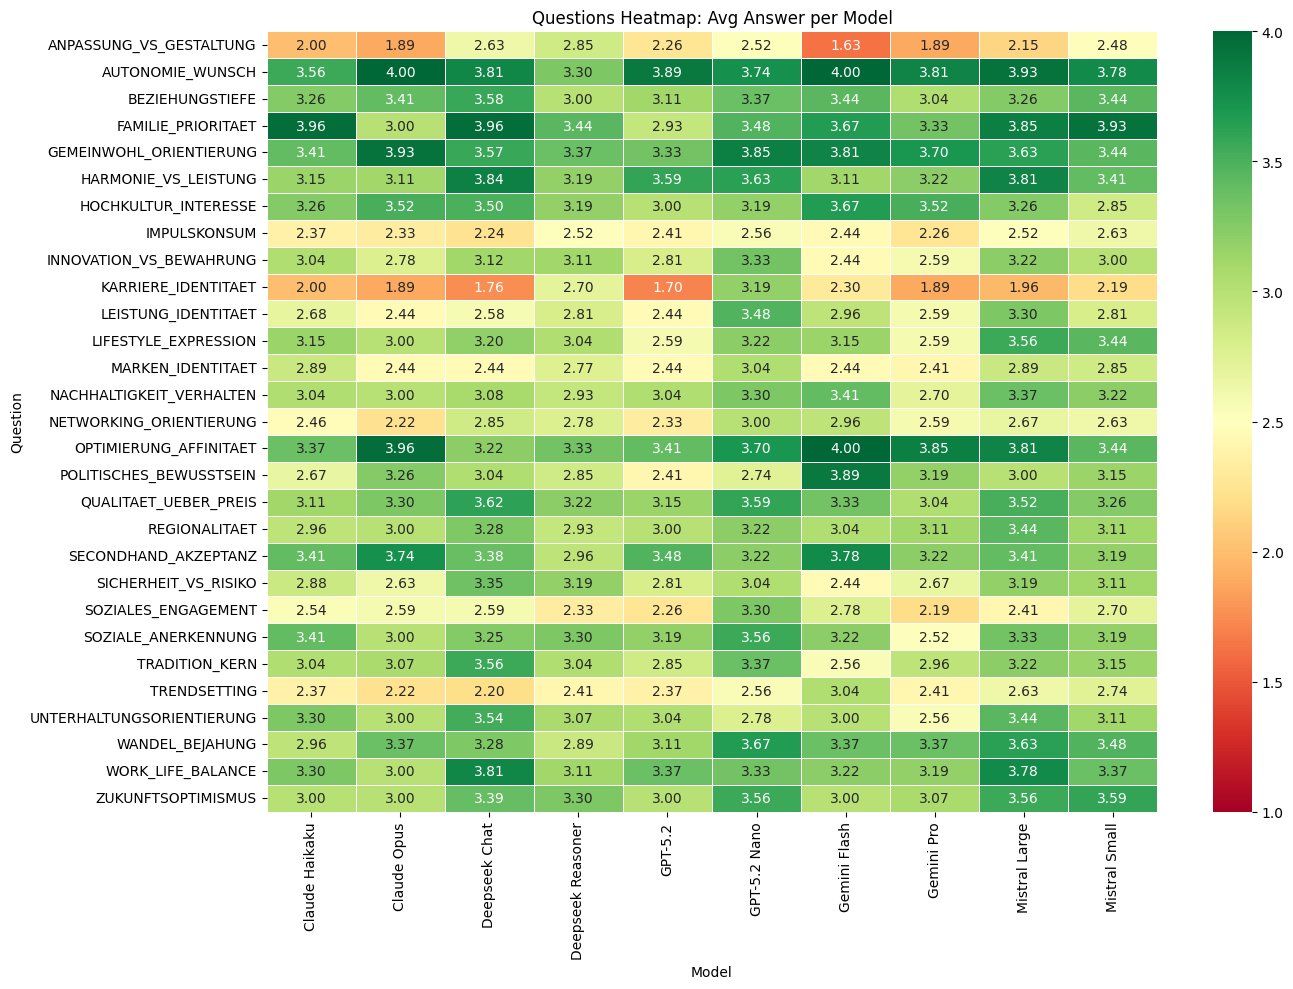

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(
    df_pivot,
    annot=True,      # Zahlen in die Zellen
    fmt='.2f',       # 2 Dezimalstellen
    cmap='RdYlGn',   # Rot-Gelb-Grün (1=Rot, 4=Grün)
    vmin=1,          # Min-Wert
    vmax=4,          # Max-Wert
    linewidths=0.5
)
plt.title('Questions Heatmap: Avg Answer per Model')
plt.xlabel('Model')
plt.ylabel('Question')
plt.tight_layout()
plt.show()

In [106]:
# Durchschnittliche Antwort pro Run (über alle 29 Fragen)
query_runs = """
    SELECT 
        r.id as run_id,
        m.name as model,
        s.name as strategy,
        AVG(resp.answer) as avg_answer,
        r.timestamp
    FROM responses resp
    JOIN runs r ON resp.run_id = r.id
    JOIN models m ON r.model_id = m.id
    JOIN strategies s ON r.strategy_id = s.id
    GROUP BY r.id
    ORDER BY m.name, s.name, r.timestamp
"""

df_runs = pd.read_sql_query(query_runs, connection)
df_runs.head()

# Wie viel streuen die Runs pro Model?
runs = df_runs[df_runs['strategy'] == 'questionbyquestion_test']

fig = px.box(
    runs,
    x='model',
    y='avg_answer',
    color='model',
    title='Answer Variance per Model',
    labels={'avg_answer': 'Avg Answer (1-4)'}
)

fig.show()

# Wie viel streuen die Runs pro Model?
runs = df_runs[df_runs['strategy'] == 'questionbyquestion_none']

fig = px.box(
    runs,
    x='model',
    y='avg_answer',
    color='model',
    title='Answer Variance per Model',
    labels={'avg_answer': 'Avg Answer (1-4)'}
)

fig.show()

# Wie viel streuen die Runs pro Model?
runs = df_runs[df_runs['strategy'] == 'oneshot_none']

fig = px.box(
    runs,
    x='model',
    y='avg_answer',
    color='model',
    title='Answer Variance per Model',
    labels={'avg_answer': 'Avg Answer (1-4)'}
)

fig.show()
